# Theory 

## Updated September 11, 2023
### Vincent Voelz

Consider $N$ total miniprotein sequences, each with dissociationa constants of $K_{d,i}$, for $i=1,...N$.  

Suppose at a given HA concentration $L$, each sequence is read $M_i(L)$ times, for a total number of $M(L) = \sum_i M_i(L)$ sequence reads.

While earlier we assumed that there is an equal number of cells expressing each miniprotein, this isn't true.  Instead, there is an initial pool of yeast displaying the binders with various efficiencies (which we can estimate from the `rd0_seqMatch` numbers).  Let $w_i$ represent these baseline counts of sequence reads. 

We assume that the fraction bound for each miniprotein is like that of a single-species binding curve :

$$ f_i(L) = \frac{L}{K_{d,i} + L}. $$

Then the probability of observing the set of $M_i$ reads is a multinomial:

$$ p(\{ M_i(L) \})=\frac{M(L) !}{M_{1}(L) ! \cdots M_{N}(L) !} p_1(L)^{M_1(L)} \cdots p_N(L)^{M_N(L)}, $$

where $p_i(L) = w_i f_i(L)/{\sum_i w_i f_i(L)}$.  The total probability of observing a set of reads at different concentrations $L$ is:

$$ p( \{ M_i(L) \} \text{for} L \in [L_1, L_2, L_3, L_4] ) = \prod_{L} \frac{M(L) !}{M_{1}(L) ! \cdots M_{N}(L) !} p_1(L)^{M_1(L)} \cdots p_N(L)^{M_N(L)}, $$






## Bayesian inference of dissociation constants $K_{d,i}$

Suppose we are given sequencing read counts as data $D = \{ M_i(L) \}$ for $L \in [L_1, L_2, L_3, L_4]$, where these are the four concentrations used in the experiment:

$$ [L_1, L_2, L_3, L_4] = [10^{-6} \text{ M}, 10^{-7} \text{ M}, 10^{-8} \text{ M}, 10^{-9} \text{ M}] $$

By Bayes' theorem, the posterior probability of the set of dissociation constants is 

$$ P( \{ K_{d,i} \} | D )  \propto     P( D | \{ K_{d,i} \} ) P(\{ K_{d,i} \}), $$

where $P( D | \{ K_{d,i} \} )$ is the likelihood of observing the sequence read data $D$ (the multinomial expression shown above), and $P(\{ K_{d,i} \})$ is a prior distribution.

For the *prior* distribution, we use known prior information about the effects of protein mutations on the stability of protein-protein interfaces published in the literature.  Geng et al (2019) published a "diverse training dataset consisting of 1102 mutations in 57 protein-protein complexes."  An analysis of this data (See "iSee_analysis.ipynb") shows the distribution of $\Delta \log_{10} K_d$ can be modeled as a Cauchy distribution:

$$ P(\Delta \log_{10} K_d | \mu, \gamma) \approx \frac{1}{\pi}\left[\frac{\gamma}{\left( \Delta \log_{10} K_d -\mu \right)^2+\gamma^2}\right] ,$$

where the average $\mu = \langle \Delta \log_{10} K_d \rangle$ = +0.532, and the scale parameter(the half-width at half-maximum, HWHM), is $\gamma$ = 0.7045.

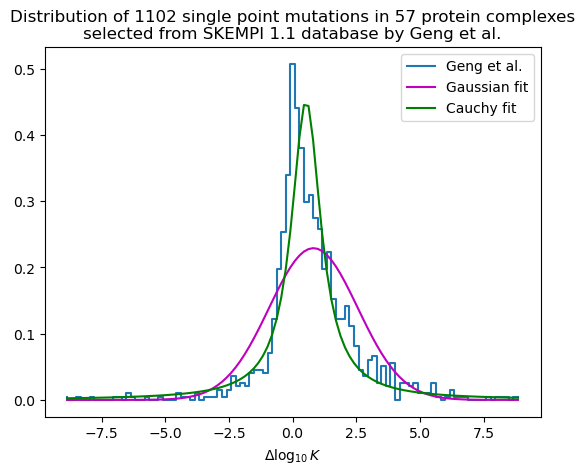

Therefore, for the prior distribution of the set of $\{ K_{d,i} \}$, we use 

$$ P( \{ K_{d,i} \}) = P( \{ K_{d,i} \} | K_d^*)P(K_d^*) = \left\{ \prod_{i=1}^N \frac{1}{\pi}\left[\frac{\gamma}{\left( \log_{10} \frac{K_{d,i}}{K_d^*} - \mu \right)^2+\gamma^2}\right] \right\} P(K_d^*), $$

where $K_d^*$ is the "baseline" $K_d$ of wild-type miniprotein binder (A8, A13 or A18), and $P(K_d^*) \sim 1/K_d^*$ is a non-informative Jefferys' prior.

For the *likelihood* distribution, we use the multinormal probabiliity of observing the sequence reads described above.


### Reference

Geng, Cunliang, Anna Vangone, Gert E. Folkers, Li C. Xue, and Alexandre M. J. J. Bonvin. “ISEE: Interface Structure, Evolution, and Energy-Based Machine Learning Predictor of Binding Affinity Changes upon Mutations.” Proteins: Structure, Function, and Bioinformatics 87, no. 2 (February 2019): 110–19. 
https://doi.org/10.1002/prot.25630.




## Sampling the posterior distribution

We can sample from the posterior distribution $P( \{ K_{d,i} \} | D )$ by using Markov Chain Monte Carlo (MCMC), using the 'energy' function

$$ u = - \ln [ P( D | \{ K_{d,i} \} ) P(\{ K_{d,i} \}) ] = - \ln P( D | \{ K_{d,i} \} ) - \ln P(\{ K_{d,i} \}|K_d^*) $$ 

where the Jeffery's prior on $K_d^*$ is enforced by using a move set over a grid of logarithmically-spaced $K_{d,i}$ values.  

Inserting the expressions for above, the energy function is

$$ u = \sum_{L} - \ln \Big[ \frac{M(L) !}{M_{1}(L) ! \cdots M_{N}(L) !} \Big]  + 
       \sum_{L} \sum_i -M_i(L) \ln \frac{w_i f_i(L)}{\sum_i w_i f_i(L)} +
       N \ln \frac{\pi}{\gamma}  + \sum_{i=1}^{N} \ln \left[ (\log_{10}K_{d,i} - \log_{10} K_d^* - \mu)^2 + \gamma^2 \right] .$$
       
The first term after the equal sign and the $N \ln \frac{\pi}{\gamma}$ term is constant with respect to the $\{ K_{d,i} \}$, and can be ignored.  The second term can be split into a term that :

$$ u =  \sum_{L} \sum_i - M_i(L) \ln w_i f_i(L) +   \sum_{L} M(L) \ln {\sum_i w_i f_i(L)} + \sum_{i=1}^{N} \ln \left[ (\log_{10}K_{d,i} - \log_{10} K_d^* - \mu)^2 + \gamma^2 \right].$$
$$ u =  \sum_{L} \sum_i - M_i(L) \ln \frac{w_iL}{K_{d,i} + L} +   \sum_{L} M(L) \ln {\sum_i \frac{w_i L}{K_{d,i} + L}} + \sum_{i=1}^{N} \ln \left[ (\log_{10}K_{d,i} - \log_{10} K_d^* - \mu)^2 + \gamma^2 \right]$$ 



# A class to store input data and perform posterior sampling of Kd values

In [1]:
import pandas as pd
import numpy as np
from natsort import natsort_keygen
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import copy


class KdSampler(object):
    """A class to store input data and perform posterior sampling to infer Kd values"""

    def __init__(self, seq_read_fn='06_HighThroughputDesign_FluH1_Gen2_relax.dat', 
                 log10Kd_baseline = -6.0, log10Kd_mu = 0.532, log10Kd_gamma = 0.7045, verbose=True):
        """Initialize the class."""
        
        if verbose:
            print('Initializing the class...')
            
        # get the A8, A13, A18 sequences
        self.wt_sequences = self.get_wt_sequences(verbose=verbose)
        
        # Read in and curate the datatable
        self.df2 = self.get_dataframe(seq_read_fn=seq_read_fn, verbose=verbose, show_df=False)
        self.sequences = self.df2['Sequence']
        self.N = len(self.sequences)
        
        # extract sequence read counts and fractions
        counts_col = '[rd0_seqMatch,rd2_1000nM_seqMatch,rd2_100nM_seqMatch,rd2_10nM_seqMatch,rd2_1nM_seqMatch]'
        self.counts = np.array([eval(row) for row in self.df2[counts_col]])
        self.totals = self.counts.sum(axis=0)
        self.fractions = self.counts/self.totals
        
        #######################################
        # Data structures for MCMC sampling
        self.log10HA_conc = np.array([-6.0, -7.0, -8.0, -9.0])
        self.HA_conc = np.array([1.0e-6, 1.0e-7, 1.0e-8, 1.0e-9])
        self.num_HA_conc = len(self.HA_conc)

        self.log10Kd_baseline = log10Kd_baseline  # log10Kd of the wt_sequences  (-6.0)
        self.log10Kd_mu = log10Kd_mu        # "mu" = location of the Cauchy
        self.log10Kd_gamma = log10Kd_gamma  # "gamma" = \Delta log10Kd of 
        self.log10Kd = self.log10Kd_baseline*np.ones(self.N)   # An array of log10Kd values for each sequence 

        assert self.counts.shape[1] == 5
        self.M = self.counts[0:self.N, 1:5]
        assert self.M.shape[1] == 4
        if (0):
            print('self.M.shape', self.M.shape)
        self.M_sum = self.M.sum(axis=0)
        
        self.w = self.counts[0:self.N, 0]  # the weights from the initial yeast pool
        # If any of the weights are zero, add a pseudocount
        for i in range(self.N):
            if self.w[i] == 0:
                self.w[i] = 1.0

        # for efficient array computation, we will fill arrays with shape of M (N,4)

        self.w_shapeM = np.transpose(np.tile(self.w, (self.num_HA_conc,1))).astype(float)
        if (1):
            print('self.w_shapeM.shape', self.w_shapeM.shape)

        self.L_shapeM = np.tile(self.HA_conc, (self.N,1))
        if (1):
            print('self.L_shapeM.shape', self.L_shapeM.shape)

        self.log10Kd_shapeM = np.zeros((self.N, self.num_HA_conc))
        self.f_shapeM       = np.zeros((self.N, self.num_HA_conc))
        
        # for storing trajectories
        self.Kd_grid_traj = []
        self.u_traj = []
        self.step_traj = []
        

    def get_wt_sequences(self, fromfile=False, verbose=True):
        """Get the A8, A13 and A18 sequences."""
        
        if verbose:
            print('Retrieving A8, A13 and A18 sequences...', end='')
              
        if (not fromfile):
            # Read in sequence data for A8, A13 and A18
            self.A8_sequence  = 'TSRVRATSKFAALIAAEIAREFGYTVDVQEVNGQWEVTFD' # A8
            self.A13_sequence = 'CIEISVTTPFACQIAAEIWRAFGYEVKIDDDNGNCRLHVC' # A13
            self.A18_sequence = 'CQDYTFTDPFACQIAAEILRDFGYDCTVQTNNGECRVRCC' # A18

        else:
            self.A8_seqfile = 'A8_sequence.afasta'
            self.A13_seqfile = 'A13_sequence.afasta'
            self.A18_seqfile = 'A18_sequence.afasta'
        
            self.A8_sequence = open(self.A8_seqfile).readlines()[0].replace('\n','')
            self.A13_sequence = open(self.A13_seqfile).readlines()[0].replace('\n','')
            self.A18_sequence = open(self.A18_seqfile).readlines()[0].replace('\n','')
            
        self.wt_sequences = [self.A8_sequence, self.A13_sequence, self.A18_sequence]

        if verbose:
            print('...Done')

        return self.wt_sequences
        
        
    def get_dataframe(self, seq_read_fn='06_HighThroughputDesign_FluH1_Gen2_relax.dat', verbose=False, show_df=False):
        """Read and curate the datatable, skipping all the info lines, so it's more managable."""

        if verbose:
            print('Getting input data...', end='')
            
        # find the header row where the data starts
        fin = open(seq_read_fn, 'r')
        lines = fin.readlines()
        fin.close()
        
        while lines[0][0:4] != '# ID':  
            lines.pop(0)
        lines[0] = lines[0].replace('# ID', '#ID')  # get rid of the space between # and ID !

        data = [line.split(' ') for line in lines]
        headers = data[0]
        self.df2 = pd.DataFrame([fields[1:] for fields in data[1:]]) # fields have '' for 1st element; skip it!
        
        self.df2.columns = headers
        # print('self.df2.columns', self.df2.columns)
        if show_df:
            print('self.df2', self.df2) 
        if verbose:
            print('...Done.')
        return self.df2

    def f(Kd, L):
        """Returns the fraction bound f = L/(Kd + L) for a single miniprotein
        INPUTS
        L     - ligand (HA) concentration in molarity (M = mol/L)
        Kd    - Dissociation constant (in M)
        """

        return L/(Kd + L)

    
    def log_f(Kd, L):
        """Returns the ln of the fraction bound f = L/(Kd + L) for a single miniprotein
        INPUTS
        L     - ligand (HA) concentration in molarity (M = mol/L)
        Kd    - Dissociation constant (in M)
        """

        return (np.log(L) - np.log(Kd + L))

    
    
    def u(self, Kd_grid_indices, debug=False):
        """Returns the neg-log posterior probability for a given set of \{ K_{d,i} \}

        INPUTS
        log10_Kd   -  a np.array of dim (N,) with a set of dissociation constants (in units M)

        PARAMETERS
        """
        
        # Update the log10Kd_shapeM array based on the current Kd indices
        log10Kd = self.log10Kd_grid[Kd_grid_indices]
        self.log10Kd_shapeM = np.transpose(np.tile(log10Kd, (self.num_HA_conc,1)))
        
        # Update the f_shapeM array based on the current Kd indices
        self.f_shapeM = self.w_shapeM * self.L_shapeM/(np.power(10.0,self.log10Kd_shapeM) + self.L_shapeM)
        if (debug):
            print('self.f_shapeM', self.f_shapeM)

        # first term
        result = np.sum(-1.0 * self.M * np.log(self.w_shapeM * self.f_shapeM))
        if debug:
            print('result', result)

        # second term
        self.f_sum = self.f_shapeM.sum(axis=0)
        result += np.sum(self.M_sum*np.log(self.f_sum))
        if debug:
            print('result 2', result)

        # third term - the cauchy penalty       
        cauchy_penalties = self.cauchy_penalty_grid[ Kd_grid_indices ]
        result += np.sum(cauchy_penalties)
        if debug:
            print('result 3', result)

        return result

    
    def update(self, rows_to_update, row_Kd_grid_indices):
        """Update the energy terms that depend on the Kd,i's'"""
         
        self.log10Kd_shapeM = np.zeros((self.N, self.num_HA_conc))
        self.f_shapeM       = np.zeros((self.N, self.num_HA_conc))

        log10Kd_to_update = self.log10Kd_grid[row_Kd_grid_indices]
        self.log10Kd_shapeM= np.transpose(np.tile(log10Kd_to_update, (self.num_HA_conc,1)))
        if (1):
            print('self.log10Kd_shapeM.shape', self.log10Kd_shapeM.shape)

        self.f_shapeM[ rows_to_update, :] = self.w_shapeM[ rows_to_update, :] * self.L_shapeM[ rows_to_update, :]/(np.power(10.0,self.log10Kd_shapeM[ rows_to_update, :]) + self.L_shapeM[ rows_to_update, :])
        if (1):
            print('self.f_shapeM', self.f_shapeM)
    
    
    

        
        
    
    def sample(self, nsteps = 100000, nmove = 10, log10Kd_min=-9.0, log10Kd_max=-3.0, dlog10Kd = 0.1,
              print_every = 1000, traj_every = 100):
        """Perform MCMC sample of the posterior probability of K_d,i values.
        
        PARAMETERS 
        
        RETURN        
        """
        
        # Initialize energies
        self.log10Kd_grid = np.arange(log10Kd_min, log10Kd_max, dlog10Kd)
        self.Kd_grid = np.power(10.0, self.log10Kd_grid)
        self.ngrid = len(self.log10Kd_grid)
        
        self.current_Kd_grid_indices = np.array(self.N*[int(self.ngrid/2)])
        self.current_log10Kd = self.log10Kd_grid[self.current_Kd_grid_indices]       
        # print('self.current_log10Kd', self.current_log10Kd)
        
        # Cauchy prior penalty
        self.cauchy_penalty_grid = np.log( (self.log10Kd_grid - self.log10Kd_baseline - self.log10Kd_mu)**2.0 + self.log10Kd_gamma**2.0 )
        # print('self.cauchy_penalty_grid', self.cauchy_penalty_grid)                        

        self.current_u = self.u(self.current_Kd_grid_indices)
        
        # nmove = 5   # number of Kd values to move at a time

        accepted = 0.0
        for step in range(nsteps):

            self.current_u = self.u(self.current_Kd_grid_indices)

            # Propose a move

            ## choose nmove Kd indices at random
            Ind = np.random.choice(self.N, size=nmove, replace=False)
            move_dirs = np.random.choice([-1,1], size=nmove, replace=True)  # move the indices up or down

            new_Kd_grid_indices = copy.copy(self.current_Kd_grid_indices)
            new_Kd_grid_indices[Ind] = np.clip(self.current_Kd_grid_indices[Ind] + move_dirs, 0, self.ngrid-1)
            # NOTE: clip() keeps grid indices in range
            
            new_u = self.u(new_Kd_grid_indices)

            # Accept or reject according to the Metropolis criterion
            accept = False
            if new_u < self.current_u:
                accept = True
            else:
                if np.exp(-1.0*(new_u - self.current_u)) > np.random.rand():
                    accept = True

            if accept:
                self.current_u = new_u
                self.current_Kd_grid_indices = new_Kd_grid_indices
                accepted += 1.0

            if step%print_every == 0:
                print('step', step, 'acc =', accept, 'ratio', accepted/(step+1.0), 'current_u', self.current_u)

            # store the 
            if step%traj_every == 0:
                self.Kd_grid_traj.append(self.current_Kd_grid_indices)
                self.u_traj.append(self.current_u)
                self.step_traj.append(step)



In [2]:
s = KdSampler()

# Perform some sampling
s.sample(nsteps=100000, print_every=100)


Initializing the class...
Retrieving A8, A13 and A18 sequences......Done
Getting input data......Done.
self.w_shapeM.shape (15490, 4)
self.L_shapeM.shape (15490, 4)
step 0 acc = False ratio 0.0 current_u 21449853.28105106
step 100 acc = True ratio 0.44554455445544555 current_u 21426874.455940135
step 200 acc = False ratio 0.43781094527363185 current_u 21408699.0854087
step 300 acc = True ratio 0.45514950166112955 current_u 21386781.534579746
step 400 acc = False ratio 0.4314214463840399 current_u 21373593.98780808
step 500 acc = True ratio 0.4291417165668663 current_u 21354255.85993639
step 600 acc = True ratio 0.43594009983361065 current_u 21335382.98087434
step 700 acc = False ratio 0.42510699001426533 current_u 21322797.120717607
step 800 acc = False ratio 0.41947565543071164 current_u 21309135.375023395
step 900 acc = False ratio 0.4117647058823529 current_u 21295944.941061907
step 1000 acc = False ratio 0.4225774225774226 current_u 21277825.21889806
step 1100 acc = False ratio 0.4

Text(0, 0.5, '$K_d$ (M)')

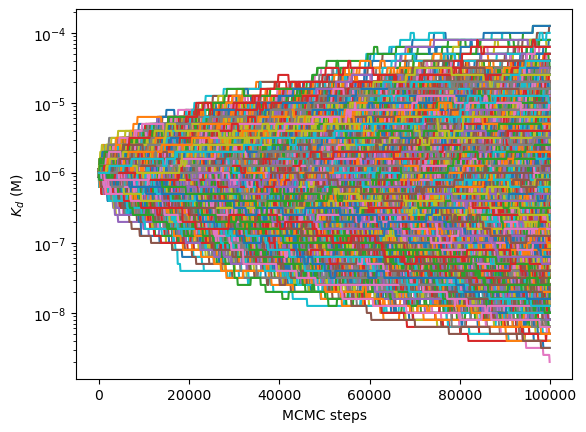

In [3]:
# plot the Kd convergenece

Kd_traj = s.Kd_grid[np.array(s.Kd_grid_traj)]
plt.plot(s.step_traj,Kd_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')


Text(0, 0.5, 'energy')

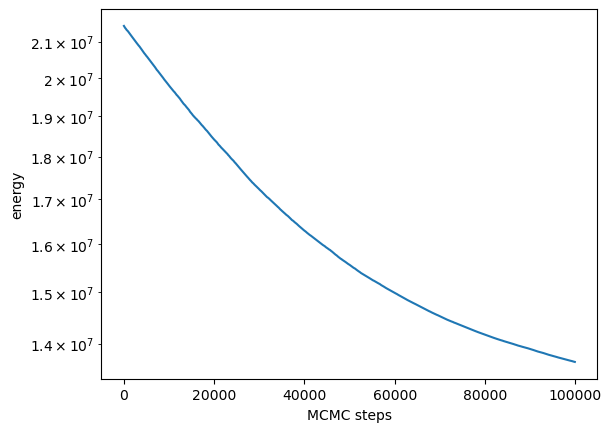

In [4]:
# Plot the convergence of the energy

plt.plot(s.step_traj, s.u_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('energy')


Text(0.5, 0, '$K_d$ (M)')

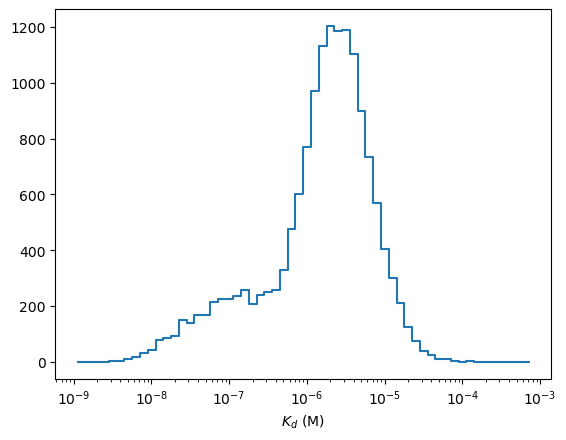

In [8]:
logbins = 10.0**(np.arange(-9,-3, 0.1))
Kd_hist, Kd_binedges = np.histogram(Kd_traj[-1,:], bins=logbins)
Kd_bincenters = (Kd_binedges[0:-1] + Kd_binedges[1:])/2.0

plt.step(Kd_bincenters, Kd_hist)
plt.xscale('log')
plt.xlabel('$K_d$ (M)')

### Perform MCMC sampling|

In [ ]:
# Perform MCMC sampling
import copy

# N = 1000   # number of sequences
N = 15463



## Initial values

current_Kd_grid_indices = np.array(N*[int(ngrid/2)])
print('current_Kd_grid_indices', current_Kd_grid_indices)
current_Kd = Kd_grid[current_Kd_grid_indices]
print('current_Kd', current_Kd)
M = counts[0:N, 1:5]
print('M.shape', M.shape)
HA_conc = [1.0e-6, 1.0e-7, 1.0e-8, 1.0e-9] # M

print('current_Kd.shape', current_Kd.shape)
print('M.shape', M.shape)

current_u = u(current_Kd, M, HA_conc)

nsteps = 1000000
nmove = 5   # number of Kd values to move at a time
print_every = 1000
traj_every = 100

Kd_grid_traj = []
step_traj = []

accepted = 0.0
for step in range(nsteps):
    
    current_u = u(current_Kd, M, HA_conc)
    
    # Propose a move
    
    ## choose nmove Kd indices at random
    Ind = np.random.choice(N, size=nmove, replace=False)
    # print('step', step, 'Ind', Ind)
    
    move_dirs = np.random.choice([-1,1], size=nmove, replace=True)  # move the indices up or down
    # print('move_dirs', move_dirs)
    
    new_Kd_grid_indices = copy.copy(current_Kd_grid_indices)
    new_Kd_grid_indices[Ind] = np.clip(new_Kd_grid_indices[Ind] + move_dirs, 0, ngrid-1)
    # NOTE: clip() keeps grid indices in range
    # print('new_Kd_grid_indices', new_Kd_grid_indices)
    
    new_Kd = Kd_grid[new_Kd_grid_indices]
    # print('new_Kd', new_Kd)

    new_u = u(new_Kd, M, HA_conc)
    
    # Accept or reject according to the Metropolis criterion
    accept = False
    if new_u < current_u:
        accept = True
    else:
        if np.exp(-1.0*(new_u - current_u)) > np.random.rand():
            accept = True

    if accept:
        current_u = new_u
        current_Kd_grid_indices = new_Kd_grid_indices
        current_Kd = new_Kd
        accepted += 1.0
        
    if step%print_every == 0:
        print('step', step, 'acc =', accept, 'ratio', accepted/(step+1.0), 'current_u', current_u)
    
    # store the 
    if step%traj_every == 0:
        Kd_grid_traj.append(current_Kd_grid_indices)
        step_traj.append(step)


# plot the results

Kd_traj = Kd_grid[np.array(Kd_grid_traj)]
        
plt.plot(step_traj,Kd_traj)
plt.yscale('log')
plt.xlabel('MCMC steps')
plt.ylabel('$K_d$ (M)')


In [ ]:
# Which sequences are inferred to have the best Kd?

print('Kd_traj.shape', Kd_traj.shape)
#print('Kd_traj[-1,:]', Kd_traj[-1,:])
top20_Kd_Ind = (np.argsort(Kd_traj[-1,:]))[0:20]
print('top20_Kd_Ind', top20_Kd_Ind)
print('# rank\tKD\tSequence')
for i in range(len(top20_Kd_Ind)):
    print(f'{i}\t{Kd_traj[-1,top20_Kd_Ind[i]]}\t{sequences[top20_Kd_Ind[i]]}')


In [ ]:
"""
A18_sequence CQDYTFTDPFACQIAAEILRDFGYDCTVQTNNGECRVRCC
A8 sequence index: 14329 TSRVRATSKFAALIAAEIAREFGYTVDVQEVNGQWEVTFD
A13 sequence index: 4352 CIEISVTTPFACQIAAEIWRAFGYEVKIDDDNGNCRLHVC
A18 sequence index: 8277 CQDYTFTDPFACQIAAEILRDFGYDCTVQTNNGECRVRCC
"""

In [ ]:
# Let's plot only the top scoring ones

plt.figure()
for i in top20_Kd_Ind:
    plt.plot(HA_conc, fractions[i,1:5], label=sequences[i])
plt.xscale('log')
plt.xlabel('HA concentation (M)')
plt.ylabel('fraction bound')
plt.legend(loc='best', fontsize=6)


In [ ]:
np.power(10.0, 2.4)



In [ ]:
a = np.arange(10)
b = np.outer(a,a)
Ind = [[i,i] for i in range(10)]
c = b[ range(10), range(10) ]


c[ [3,3,3,3,3,3,3,3] ]